In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
DATA_DIR = "./data"
MANIFEST_FILE = os.path.join(DATA_DIR, "runs_manifest.csv")
SWEEPS_DIR = os.path.join(DATA_DIR, "sweeps")

In [4]:
# --- 1. LOAD MANIFEST (The Phonebook) ---
def load_manifest():
    """Loads the lightweight metadata index."""
    if not os.path.exists(MANIFEST_FILE):
        raise FileNotFoundError("Manifest not found! Run the downloader script first.")
    return pd.read_csv(MANIFEST_FILE)

# --- 2. FIND SWEEP ID (The Search Tool) ---
def find_sweep_id(manifest, search_term):
    """
    Helps you find the sweep_id based on a run name or config.
    Example: find_sweep_id(manifest, "polar_safety")
    """
    # Search in config keys
    matches = manifest[manifest.apply(lambda row: row.astype(str).str.contains(search_term).any(), axis=1)]

    if matches.empty:
        print(f"No sweeps found matching '{search_term}'")
        return None

    unique_sweeps = matches["sweep_id"].unique()
    print(f"Found {len(unique_sweeps)} matching sweeps:")
    for sw in unique_sweeps:
        # Get a sample run name to help identify it
        sample_name = matches[matches["sweep_id"] == sw].iloc[0]["run_name"]
        print(f"  - ID: {sw} (Sample Run: {sample_name})")

    return unique_sweeps[0] if len(unique_sweeps) == 1 else unique_sweeps

# --- 3. LOAD SWEEP DATA (The Heavy Lifter) ---
def load_sweep_data(sweep_id, manifest):
    """
    Loads the time-series data for ONE sweep and joins it with Hyperparameters.
    """
    filepath = os.path.join(SWEEPS_DIR, f"sweep_{sweep_id}.csv")

    print(f"Loading data for Sweep {sweep_id}...")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    # 1. Load History (Metrics over time)
    df_history = pd.read_csv(filepath, low_memory=False)

    # 2. Prepare Metadata (Hyperparameters)
    # Filter manifest to just this sweep's runs to speed up merge
    sweep_meta = manifest[manifest["sweep_id"] == sweep_id].copy()

    # Select useful columns (Config + Identifiers)
    # We grab everything starting with 'config_'
    meta_cols = ["run_id", "run_name", "state"] + \
                [c for c in sweep_meta.columns if c.startswith("config_")]

    # 3. Merge (SQL-style Join)
    # history.run_id <-> manifest.run_id
    df_merged = pd.merge(df_history, sweep_meta[meta_cols], on="run_id", how="left")

    print(f"Loaded {len(df_merged)} rows. Columns: {len(df_merged.columns)}")
    return df_merged

# --- 4. THE FAST PLOTTER (Updated for Flattened Configs) ---
def plot_sweep(df, x, y, hue=None, title=None, log_scale=False):
    plt.figure(figsize=(10, 6))

    sns.lineplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        errorbar="sd"
    )

    if log_scale:
        plt.yscale("log")

    clean_title = title if title else f"{y} vs {x}"
    plt.title(clean_title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [5]:
# Load Metadata
manifest = load_manifest()

# Find the sweep where you tested "Safety Factor"
# This prints the ID you need (e.g., "5pllqyjx")
sweep_ids = find_sweep_id(manifest, "polar_safety")

Found 28 matching sweeps:
  - ID: bbxdd87r (Sample Run: dutiful-sweep-2)
  - ID: bfj88tht (Sample Run: decent-sweep-6)
  - ID: 5pllqyjx (Sample Run: jolly-sweep-1)
  - ID: manual_runs (Sample Run: prime-sweep-5)
  - ID: j7qzf95f (Sample Run: firm-sweep-15)
  - ID: t8splz5x (Sample Run: dry-sweep-5)
  - ID: k1b5yfbn (Sample Run: sandy-sweep-1)
  - ID: hkw05gba (Sample Run: sandy-sweep-3)
  - ID: u7hh6wc8 (Sample Run: bright-sweep-3)
  - ID: eifb7cyl (Sample Run: solar-sweep-1)
  - ID: ulrdsxlx (Sample Run: comfy-sweep-1)
  - ID: pxrm9xt8 (Sample Run: warm-sweep-14)
  - ID: 05cfprpx (Sample Run: lively-sweep-1)
  - ID: rb2rgyx9 (Sample Run: cosmic-sweep-1)
  - ID: qmzevjll (Sample Run: decent-sweep-2)
  - ID: lh2tzeh1 (Sample Run: rich-sweep-1)
  - ID: d4c0fgt9 (Sample Run: amber-sweep-1)
  - ID: 25cht4go (Sample Run: proud-sweep-4)
  - ID: t5adqjx0 (Sample Run: vocal-sweep-5)
  - ID: lyncbpdx (Sample Run: scarlet-sweep-3)
  - ID: rs6k5h9h (Sample Run: grateful-sweep-9)
  - ID: crvl272m 

Loading data for Sweep 5pllqyjx...
Loaded 1464 rows. Columns: 220


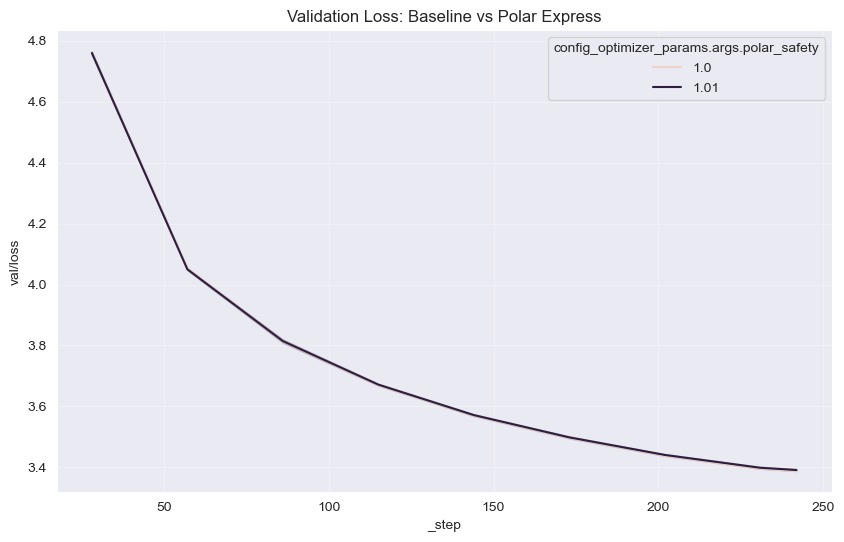

In [12]:
# Load the specific sweep file
# Replace '5pllqyjx' with the ID printed above
df = load_sweep_data("5pllqyjx", manifest)

# Plot Training Loss
# Note: The hue is now the FLATTENED config name
plot_sweep(
    df,
    x="_step",
    y="val/loss",
    hue="config_optimizer_params.args.polar_safety",
    title="Validation Loss: Baseline vs Polar Express"
)

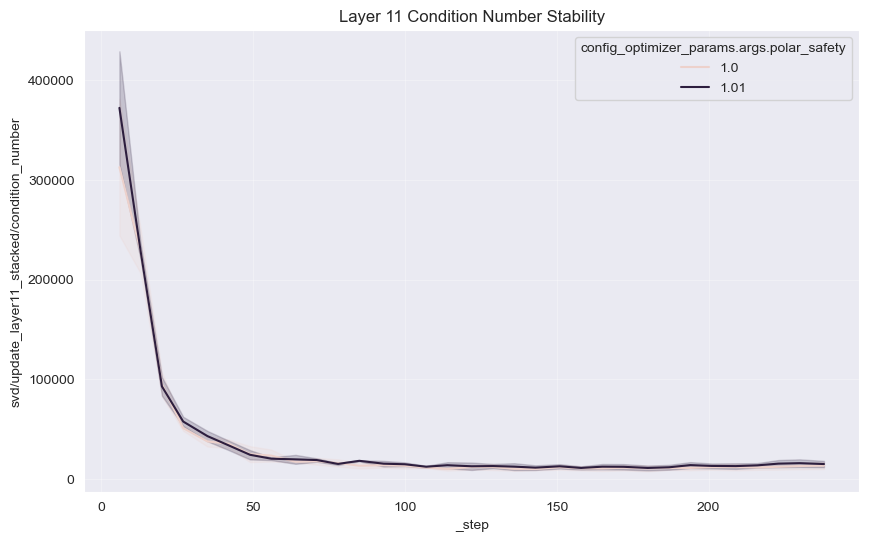

In [7]:
# Plot Condition Number
plot_sweep(
    df,
    x="_step",
    y="svd/update_layer11_stacked/condition_number",
    hue="config_optimizer_params.args.polar_safety",
    title="Layer 11 Condition Number Stability",
    log_scale=False
)